# 데이터 소개

* 출처: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data 

# 신용카드 고객 이탈 예측 - EDA (Exploratory Data Analysis)

이 노트북은 신용카드 고객 이탈(Churn) 예측을 위한 기본적인 탐색적 데이터 분석을 수행합니다.

## 목차
1. 데이터 로드 및 기본 정보 확인
2. 데이터 품질 체크 (결측치, 이상치)
3. 통계적 변수 분석
4. 상관관계 분석
5. 최동 Feature Engineering 아이디어 구성


## 1. 데이터 로드 및 기본 정보 확인

In [ ]:
# 필요한 라이브러리 임포트 
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 데이처 로드  
df = pd.read_csv('../../data/raw/BankChurners.csv')
drop_cols = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

In [ ]:
df = pd.read_csv("../../data/raw/BankChurners.csv")

# 1) Attrition Flag 원본이 없는 경우 → One-hot 인코딩 기반으로 생성
if "Attrition_Flag" not in df.columns:
    if "Attrition_Flag_Existing Customer" in df.columns:
        df["Attrition_binary"] = df["Attrition_Flag_Existing Customer"].apply(
            lambda x: 0 if x == True else 1
        )
else:
    df["Attrition_binary"] = df["Attrition_Flag"].map({
        "Existing Customer": 0,
        "Attrited Customer": 1
    })

# 2) 필요 없는 3개 컬럼 제거
drop_cols = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]
df = df.drop(columns=drop_cols, errors="ignore")

# 3) Correlation 계산을 위한 numeric만 선택
numeric_df = df.select_dtypes(include=[np.number])

corr = numeric_df.corr()["Attrition_binary"].sort_values(ascending=False)

print("=== Correlation 기반 Top Features ===")
print(corr.head(15))

=== Correlation 기반 Top Features ===
Attrition_binary            1.000
Contacts_Count_12_mon       0.204
Months_Inactive_12_mon      0.152
Dependent_count             0.019
Customer_Age                0.018
Months_on_book              0.014
Avg_Open_To_Buy            -0.000
Credit_Limit               -0.024
Total_Amt_Chng_Q4_Q1       -0.131
Total_Relationship_Count   -0.150
Total_Trans_Amt            -0.169
Avg_Utilization_Ratio      -0.178
Total_Revolving_Bal        -0.263
Total_Ct_Chng_Q4_Q1        -0.290
Total_Trans_Ct             -0.371
Name: Attrition_binary, dtype: float64


In [6]:
# 처음 5개 행 확인
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061,0.000,1.000
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105,0.000,1.000
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000,0.000,1.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000,2517,796.000,1.405,1171,20,2.333,0.760,0.000,1.000
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000,0.000,1.000


## 2. 데이터 품질 체크

In [5]:
# xgb_grid 프로그램 다운받기 

'xgb_grid' in globals(), 'train_test_split' in globals()  # train_test_split은 함수라 globals에서 바로 안보일 수 있음

(False, True)

In [6]:
# 'Unknown' 문자열을 결측치로 간주
unknown_values = pd.Series(dtype=int)
for col in df.select_dtypes(include='object').columns:
    unknown_count = (df[col].str.lower() == 'unknown').sum()
    if unknown_count > 0:
        unknown_values[col] = unknown_count

# 결측치 정보
missing_df = pd.DataFrame({
    'Unknown_Count': unknown_values,
    'Missing_Percent': (unknown_values / len(df)) * 100
})
missing_df = missing_df[missing_df['Unknown_Count'] > 0].sort_values('Unknown_Count', ascending=False)

if len(missing_df) > 0:
    print("결측치가 있는 컬럼 ('Unknown' 포함):")
    print(missing_df)
    print(f"\n총 결측치 비율: {(missing_df['Unknown_Count'].sum() / (len(df) * len(df.columns))) * 100:.2f}%")
else:
    print("✓ 결측치가 없습니다!")


결측치가 있는 컬럼 ('Unknown' 포함):
                 Unknown_Count  Missing_Percent
Education_Level           1519           15.000
Income_Category           1112           10.981
Marital_Status             749            7.396

총 결측치 비율: 1.59%


In [7]:
# 중복 행 확인
duplicates = df.duplicated().sum()
print(f"중복 행 개수: {duplicates}")

if duplicates > 0:
    print(f"\n⚠️ 중복 행이 {duplicates}개 있습니다. 확인이 필요합니다.")
else:
    print("✓ 중복 행이 없습니다!")

중복 행 개수: 0
✓ 중복 행이 없습니다!


## 3. 통계적 변수 분석

                 Total_Trans_Amt  Total_Trans_Ct
Dependent_count                                 
0                       4110.332          61.711
1                       4411.088          64.054
2                       4475.953          65.430
3                       4309.107          64.629
4                       4469.992          65.770
5                       4917.356          69.575


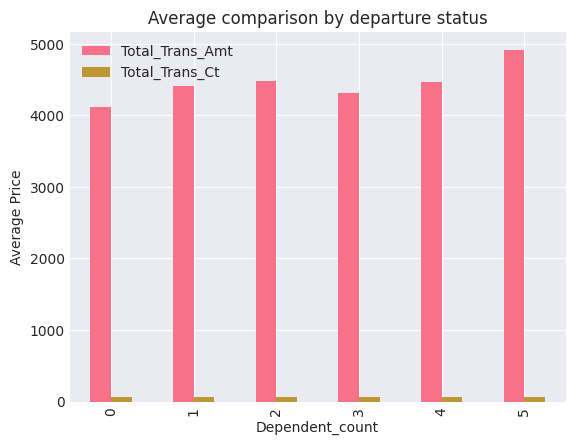

In [ ]:
# 범주형 변수 시각화 및 이탈률 비교 

target_cols = ["Total_Trans_Amt", "Total_Trans_Ct"]
group_mean = df.groupby("Dependent_count")[target_cols].mean()
print(group_mean)

group_mean.plot(kind="bar")
plt.title("Average comparison by departure status")
plt.ylabel("Average Price")
plt.show()

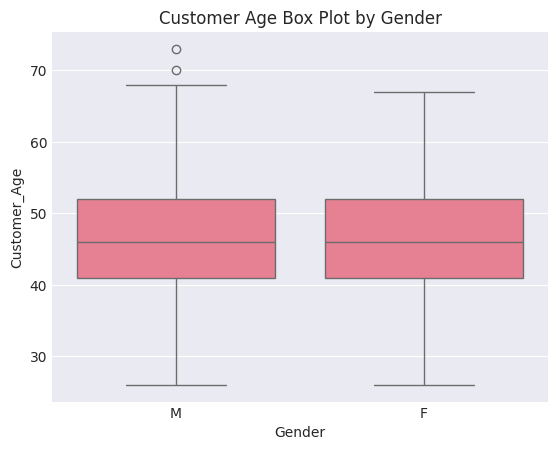

In [ ]:
# 고객 연령대별 성별 분포 박스플롯 생성

sns.boxplot(x="Gender", y="Customer_Age", data=df)
plt.title("Customer Age Box Plot by Gender")
plt.show()

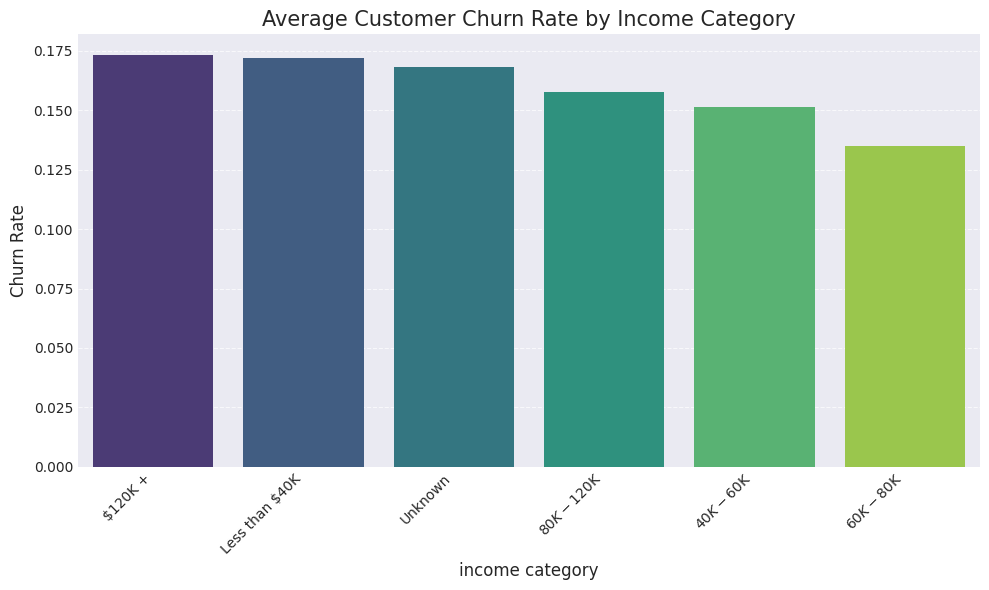

In [31]:
# Attrition_Flag를 이진 변수(1: 이탈, 0: 유지)로 변환
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# 이탈률 분석을 위한 그룹화: 'Income_Category' (소득 범주) 및 'Churn'
grouped_churn = df.groupby('Income_Category')['Churn'].mean().reset_index()
grouped_churn = grouped_churn.sort_values(by='Churn', ascending=False)

# --- 소득 범주별 평균 이탈률 막대 그래프 (Bar Chart) 출력 코드 ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Category', y='Churn', data=grouped_churn, palette='viridis')
plt.title('Average Customer Churn Rate by Income Category', fontsize=15)
plt.xlabel('income category', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 그래프를 화면에 출력합니다. (plt.savefig() 대신 plt.show() 사용)
plt.show()


--- [1. 전체 평균 이탈률] ---
전체 평균 이탈률: 0.1607 (16.07%)

--- [1. 다양한 이탈률 평균 그래프 코드 생성] ---
-> 소득 범주별 이탈률 막대 그래프: 'churn_rate_by_income.png' 저장
-> 고객 연령별 이탈 여부 밀도 그래프: 'churn_distribution_by_age.png' 저장
-> 고객 연령별 이탈 여부 밀도 그래프: 'churn_distribution_by_age.png' 저장


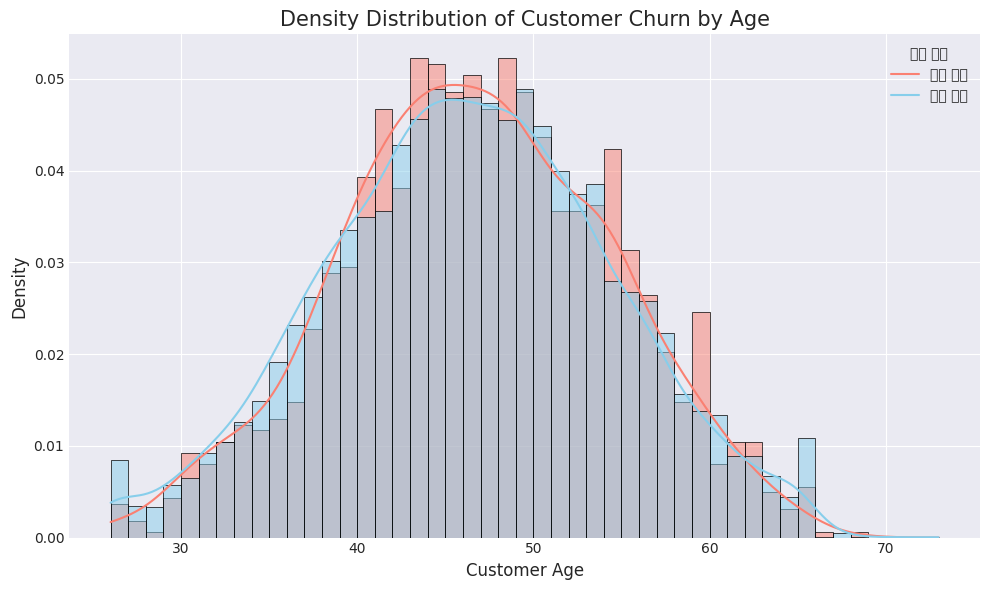

In [ ]:
# --- 이탈률 분석 및 그래프 생성 준비 (Churn Analysis & Prep) ---

# Attrition_Flag를 이진 변수(1: 이탈, 0: 유지)로 변환
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# 전체 평균 이탈률 계산
overall_churn_rate = df['Churn'].mean()
print(f"\n--- [1. 전체 평균 이탈률] ---")
print(f"전체 평균 이탈률: {overall_churn_rate:.4f} ({overall_churn_rate * 100:.2f}%)")

# 이탈률 분석을 위한 2개 열 선택: 'Income_Category' (소득 범주) 및 'Churn'
grouped_churn = df.groupby('Income_Category')['Churn'].mean().reset_index()
grouped_churn = grouped_churn.sort_values(by='Churn', ascending=False)

# --- 1. 다양한 그래프 코드 생성 (Visualization Code Generation) ---
print("\n--- [1. 다양한 이탈률 평균 그래프 코드 생성] ---")

# 1-A. 소득 범주별 평균 이탈률 (막대 그래프: Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Category', y='Churn', data=grouped_churn, palette='viridis')
plt.title('소득 범주별 고객 평균 이탈률', fontsize=15)
plt.xlabel('소득 범주', fontsize=12)
plt.ylabel('평균 이탈률 (Churn Rate)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('churn_rate_by_income.png')
print("-> 소득 범주별 이탈률 막대 그래프: 'churn_rate_by_income.png' 저장")
plt.close()

# 1-B. 고객 연령별 이탈 여부 분포 (밀도 그래프: Distribution Plot)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df, 
    x='Customer_Age', 
    hue='Attrition_Flag', 
    kde=True, 
    palette={'Existing Customer': 'skyblue', 'Attrited Customer': 'salmon'},
    stat="density", 
    common_norm=False,
    linewidth=0.5
)
plt.title('Density Distribution of Customer Churn by Age', fontsize=15)
plt.xlabel('Customer Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='이탈 여부', labels=['이탈 고객', '기존 고객'])
plt.tight_layout()
plt.savefig('churn_distribution_by_age.png')
print("-> 고객 연령별 이탈 여부 밀도 그래프: 'churn_distribution_by_age.png' 저장")
plt.show()

## 4. 상관관계 분석

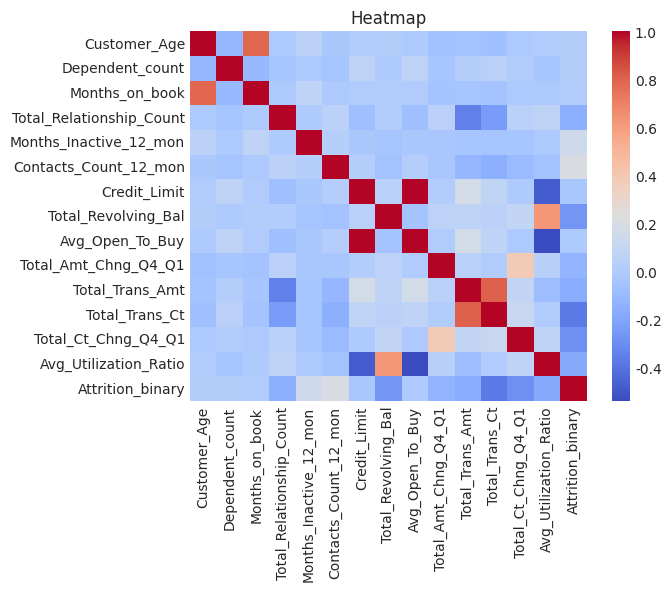

In [9]:
# 수치형 변수들 상관관계 히트맵 시각화 
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Heatmap")
plt.show()

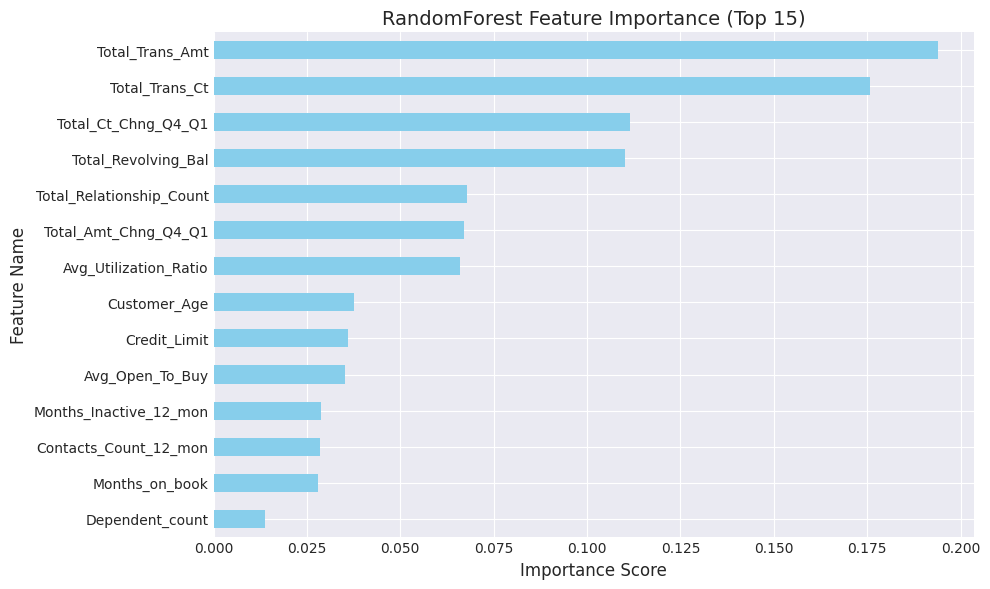

In [13]:
# 숫자형 데이터 선택
numeric_df = df.select_dtypes(include=[np.number])

X = numeric_df.drop(columns=["Attrition_binary"], errors="ignore")
y = numeric_df["Attrition_binary"]

# 결측치 처리
X = X.fillna(0)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RandomForest 모델 학습
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Feature Importance 계산
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

# 그래프 생성
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title("RandomForest Feature Importance (Top 15)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.tight_layout()
plt.show()

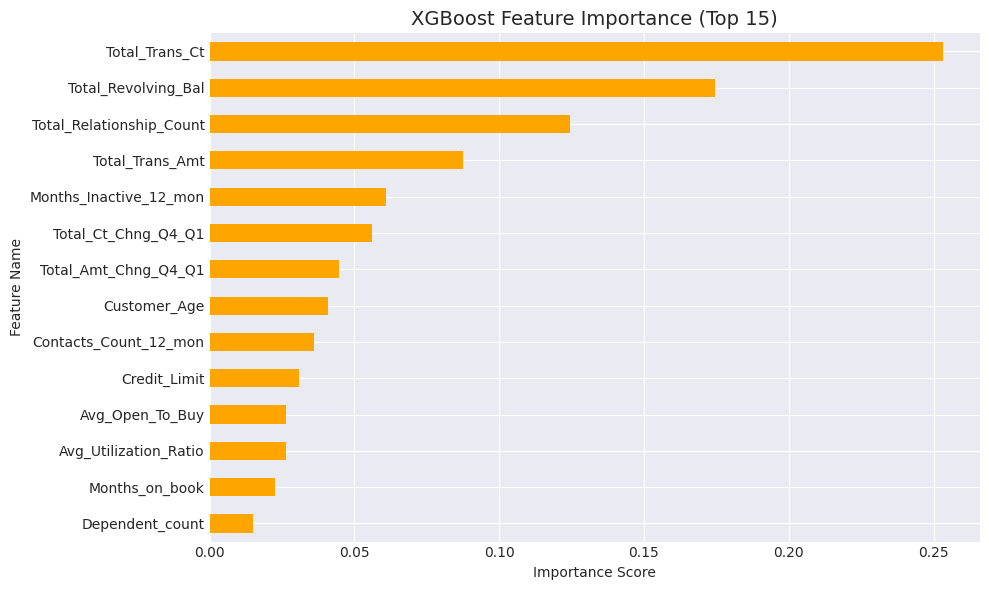


=== XGBoost 상위 Feature 15개 ===
Total_Trans_Ct             0.253
Total_Revolving_Bal        0.174
Total_Relationship_Count   0.124
Total_Trans_Amt            0.088
Months_Inactive_12_mon     0.061
Total_Ct_Chng_Q4_Q1        0.056
Total_Amt_Chng_Q4_Q1       0.045
Customer_Age               0.041
Contacts_Count_12_mon      0.036
Credit_Limit               0.031
Avg_Open_To_Buy            0.026
Avg_Utilization_Ratio      0.026
Months_on_book             0.023
Dependent_count            0.015
dtype: float32

XGBoost 모델 정확도 테스트용:
Train Score: 0.9983
Test Score:  0.9640


In [14]:
# XGBoost 상관관계 분석

numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=["Attrition_binary"], errors="ignore")
y = numeric_df["Attrition_binary"]


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) XGBoost 모델 학습
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

# 7) Feature Importance 계산
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_xgb = xgb_importance.sort_values(ascending=False).head(15)

# 8) 그래프 출력
plt.figure(figsize=(10, 6))
top_xgb.sort_values().plot(kind='barh', color='orange')
plt.title("XGBoost Feature Importance (Top 15)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# 9) 추가 분석 결과 출력
print("\n=== XGBoost 상위 Feature 15개 ===")
print(top_xgb)

print("\nXGBoost 모델 정확도 테스트용:")
print(f"Train Score: {xgb_model.score(X_train, y_train):.4f}")
print(f"Test Score:  {xgb_model.score(X_test, y_test):.4f}")

## 5. 최종 Feature Engineering 아이디어

In [21]:
# 파생 변수 생성 예시
print("파생 변수 생성 중...\n")

# NaN 값 처리 후 Feature Engineering

# 1) 거래 변화율 (거래 횟수 대비 분기 변화 비율)
df["Trans_Change_Ratio"] = (
    df["Total_Trans_Ct"] / (df["Total_Ct_Chng_Q4_Q1"] + 1)
)
print("✓ 거래 변화율 생성")

# 2) 비활동 기반 리스크 스코어
df["Inactivity_Score"] = (
    df["Months_Inactive_12_mon"] * df["Avg_Utilization_Ratio"]
)
print("✓ 비활동 기반 리스크 스코어 생성")

# 3) 고객 참여도 스코어 (Engagement Score)
df["Engagement_Score"] = (
    df["Total_Trans_Amt"] * 0.4 +
    df["Total_Trans_Ct"] * 0.4 -
    df["Months_Inactive_12_mon"] * 0.2
)
print("✓ 고객 참여도 스코어 생성")

# 4) Utilization 기반 위험 구간화
# Avg_Utilization_Ratio의 NaN 값을 먼저 0으로 채우기

df["Utilization_Risk_Level"] = pd.cut(
    df["Avg_Utilization_Ratio"].fillna(0),
    bins=[0, 0.3, 0.6, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)
print("✓ Utilization 기반 위험 구간화 생성")

print("✓ Feature Engineering 완료!")
print(f"생성된 파생 변수: Trans_Change_Ratio, Inactivity_Score, Engagement_Score, Utilization_Risk_Level")
print(f"최종 데이터 shape: {df.shape}")
print("\n파생 변수 생성 완료!")

파생 변수 생성 중...

✓ 거래 변화율 생성
✓ 비활동 기반 리스크 스코어 생성
✓ 고객 참여도 스코어 생성
✓ Utilization 기반 위험 구간화 생성
✓ Feature Engineering 완료!
생성된 파생 변수: Trans_Change_Ratio, Inactivity_Score, Engagement_Score, Utilization_Risk_Level
최종 데이터 shape: (10127, 25)

파생 변수 생성 완료!
